In [2]:
!pip install tensorflow
!pip install librosa


  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=897650fb0e6884a1bd1c7456dd4b58ef13470e24b62a4006711f84837c270f2b
  Stored in directory: c:\users\home\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23154 sha256=a852bdcc680a6f4790538b387a9c3126825ef90ac609395bcd9e5e8ebd07078a
  Stored in directory: c:\users\home\appdata\local\pip\cache\wheels\a2\a3\bd\ec1568ce7515115a11ab686d509ad302124c782af065de47ee
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320731 sha256=1e3a8566d94c023577035cef0d23e9d40c74029863714aece6d664144d58864e
  Stored in directory: c:\users\home\appdata\local\pip\cache\wheels\86\2c\7d\46a32a246b0e5939cea2c5ec1492164073e0c5d16d666ae2cd
Successfully built audioread resampy


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob

import librosa
import librosa.display as dsp
import IPython.display as ipd

In [4]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(813)

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
# sr = 20000
sr = 16000

In [7]:
for i in os.listdir('./data/train')[:3]:
  print(f'{i}')
  data, sample_rate = librosa.load(f'./data/train/{i}', sr=sr)
  print('sample_rate:', sample_rate, ', audio shape:', data.shape)
  print('length:', data.shape[0]/float(sample_rate), 'secs')
  print('\n')

001.wav
sample_rate: 16000 , audio shape: (10192,)
length: 0.637 secs


002.wav
sample_rate: 16000 , audio shape: (10501,)
length: 0.6563125 secs


004.wav
sample_rate: 16000 , audio shape: (10328,)
length: 0.6455 secs




In [8]:
from tqdm.notebook import tqdm

train_file_names = train["file_name"].to_numpy()
test_file_names = test["file_name"].to_numpy()
target = train["label"].to_numpy()

def load_audio(file_names, target, path):   
  audios = []
  for audio in tqdm(file_names):
    # librosa를 이용하여 데이터 로드
    an_audio, _ = librosa.load(path+audio, sr=sr)
    audio_array = np.array(an_audio)
    audios.append(audio_array)
  audios = np.array(audios)

  targets = target.copy()

  return audios, targets

In [9]:
audio_train, target_train = load_audio(train_file_names, target, path='./data/train/')
audio_test, _ = load_audio(test_file_names, np.array([None]), path='./data/test/')

  0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\home\AppData\Local\Temp/ipykernel_10188/1117055676.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audios = np.array(audios)


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\home\AppData\Local\Temp/ipykernel_10188/4281843164.py:6: FutureWarning: Pass y=[ 0.00026429  0.00046466  0.0004577  ... -0.0002308  -0.00022379
 -0.00027116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
C:\Users\home\AppData\Local\Temp/ipykernel_10188/4281843164.py:15: FutureWarning: Pass y=[ 0.00026429  0.00046466  0.0004577  ... -0.0002308  -0.00022379
 -0.00027116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)


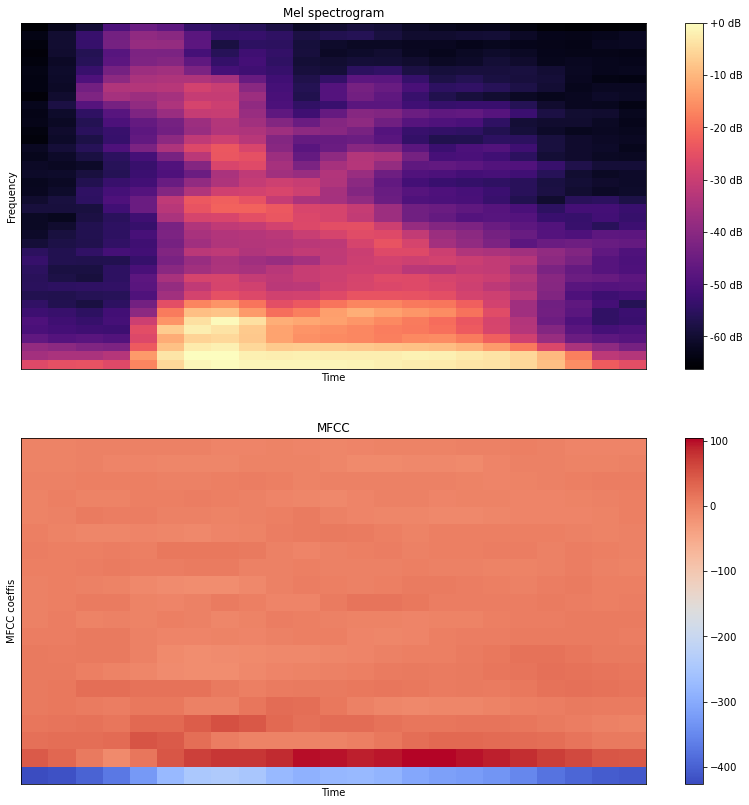

In [10]:
plt.figure(figsize=(14,14))
ax = plt.subplot(2, 1, 1)


ax = plt.subplot(2, 1, 1)
S = librosa.feature.melspectrogram(audio_train[15], sr=sr, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr)
plt.title('Mel spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

ax = plt.subplot(2, 1, 2)
mfcc = librosa.feature.mfcc(audio_train[15], sr=sr, n_mels=40)
librosa.display.specshow(mfcc, sr=sr)
plt.title('MFCC')
plt.xlabel("Time")
plt.ylabel("MFCC coeffis")
plt.colorbar()

In [11]:
def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')


  return mels

In [12]:
size = 40
pad_size = 40
repeat_size = 5

In [13]:
audio_mels = []
audio_mfcc = []

for y in audio_train:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

C:\Users\home\AppData\Local\Temp/ipykernel_10188/576866363.py:5: FutureWarning: Pass y=[0.00011985 0.00016175 0.00017247 ... 0.00019442 0.00018132 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
C:\Users\home\AppData\Local\Temp/ipykernel_10188/576866363.py:8: FutureWarning: Pass y=[0.00011985 0.00016175 0.00017247 ... 0.00019442 0.00018132 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
C:\Users\home\AppData\Local\Temp/ipykernel_10188/576866363.py:5: FutureWarning: Pass y=[ 1.26534533e-05  2.38922621e-05 -7.51331982e-06 ...  1.06650514e-04
  1.36820716e-04  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
C:\Users\home\AppData\

In [14]:
audio_mels_array_test = []
audio_mfcc_array_test = []

for y in audio_test:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)

  audio_mels_array_test.append(random_pad(mels, pad_size=pad_size, mfcc=False))
  audio_mfcc_array_test.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

C:\Users\home\AppData\Local\Temp/ipykernel_10188/1858112433.py:5: FutureWarning: Pass y=[-0.0001526  -0.00027299 -0.00026864 ... -0.00040927 -0.00046625
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
C:\Users\home\AppData\Local\Temp/ipykernel_10188/1858112433.py:8: FutureWarning: Pass y=[-0.0001526  -0.00027299 -0.00026864 ... -0.00040927 -0.00046625
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
C:\Users\home\AppData\Local\Temp/ipykernel_10188/1858112433.py:5: FutureWarning: Pass y=[4.8952625e-04 8.5201755e-04 7.6409266e-04 ... 9.4575218e-05 1.5044938e-04
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
C:\Users\home\App

In [15]:
audio_mels_array = np.array(audio_mels, np.float64)
audio_mfcc_array = np.array(audio_mfcc, np.float64)

audio_mels_array_test = np.array(audio_mels_array_test, np.float64)
audio_mfcc_array_test = np.array(audio_mfcc_array_test, np.float64)

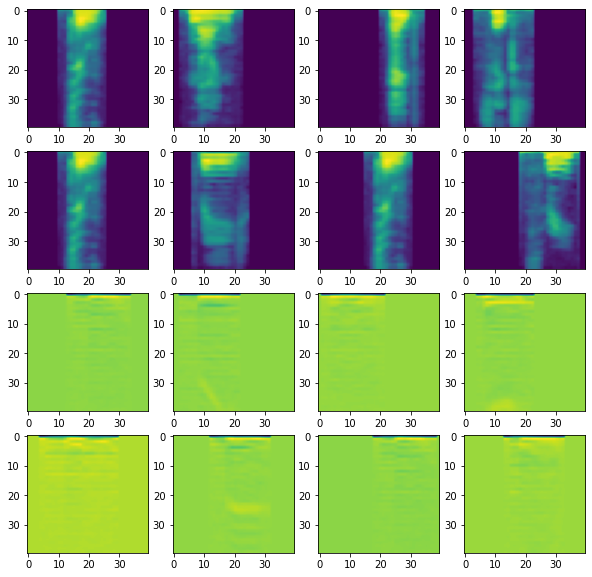

In [16]:
target_num = 2
target_num_idx = np.where(target_train==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

In [17]:
from sklearn.model_selection import train_test_split

repeated_target = np.repeat(target_train,repeat_size)
# x_train, x_val, y_train, y_val = train_test_split(audio_cqt_array, repeated_target, test_size=0.2, random_state=813, stratify=repeated_target)

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [19]:
def residual_block(x, filters_in, filters_out):
    shortcut = x
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)    
    x = Conv2D(filters_in, kernel_size=(3, 3), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)
    x = ReLU()(x)  
    x = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(x)

    shortcut_channel = x.shape.as_list()[0]
    
    if shortcut_channel != filters_out:
        shortcut = Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same",kernel_initializer='he_normal')(shortcut)
        
    x = Add()([x, shortcut])
    return ReLU()(x)

In [20]:
def build_model():

  inputs = tf.keras.layers.Input(shape=(size,pad_size,1))

  outputs = Conv2D(16,(3,3),activation=None,padding='same',kernel_initializer='he_normal')(inputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = MaxPool2D((2,2))(outputs)

  outputs = residual_block(outputs, 16, 32)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 32, 32)
  # outputs = residual_block(outputs, 32, 32)
  outputs = residual_block(outputs, 32, 64)
  outputs = MaxPool2D((2,2))(outputs)
  outputs = residual_block(outputs, 64, 64)
  # outputs = residual_block(outputs, 64, 64)
  # outputs = MaxPool2D((2,2))(outputs)

  outputs = GlobalAveragePooling2D()(outputs)
  # outputs = Flatten()(outputs)

  outputs = Dense(32,activation=None,kernel_initializer='he_normal')(outputs)
  outputs = BatchNormalization()(outputs)
  outputs = ReLU()(outputs)
  outputs = Dropout(0.5)(outputs)

  outputs = Dense(10,activation='softmax')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

# model = build_model()
# model.summary()

In [21]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

acc_list = []
pred_list = []
skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, repeated_target)):

  print(f'\n********** {fold+1} fold **********')

  preds_val_list = []
  ### melspectrogram ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mels_array[train_index], audio_mels_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mels_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mels_array_test))
  print(f'mels_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### mfcc ###
  model = build_model()
  x_train, x_val, y_train, y_val = audio_mfcc_array[train_index], audio_mfcc_array[val_index], repeated_target[train_index], repeated_target[val_index]
  filepath = f"model.res_test_0615_mfcc_{fold}.hdf5"
  callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')]
  history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), callbacks=callbacks, verbose=0)
  model = load_model(filepath)

  preds_val = model.predict(x_val)
  preds_val_list.append(preds_val)
  preds_val_label = np.argmax(preds_val, axis=1)
  pred_list.append(model.predict(audio_mfcc_array_test))
  print(f'mfcc_model_acc : {accuracy_score(y_val,preds_val_label):.4f}')

  ### ensemble ###
  val_pred_result = preds_val_list[0].copy()
  for i in range(1, len(preds_val_list)):
      val_pred_result += preds_val_list[i]
  val_pred_label = np.argmax(val_pred_result, axis=1)
  en_acc = accuracy_score(y_val,val_pred_label)
  acc_list.append(en_acc)
  print(f'ensemble_model_acc : {en_acc:.4f}')

print(f'\n\nmean_acc : {np.mean(acc_list):.4f}')


********** 1 fold **********
7/7 [==============================] - 0s 12ms/step
mels_model_acc : 0.9675
7/7 [==============================] - 0s 16ms/step
mfcc_model_acc : 0.9450
ensemble_model_acc : 0.9900

********** 2 fold **********
7/7 [==============================] - 0s 13ms/step
mels_model_acc : 0.9650
7/7 [==============================] - 0s 15ms/step
mfcc_model_acc : 0.9400
ensemble_model_acc : 0.9700

********** 3 fold **********
7/7 [==============================] - 0s 14ms/step
mels_model_acc : 0.9600
7/7 [==============================] - 0s 14ms/step
mfcc_model_acc : 0.9250
ensemble_model_acc : 0.9775

********** 4 fold **********
7/7 [==============================] - 0s 23ms/step
mels_model_acc : 0.9050
7/7 [==============================] - 0s 15ms/step
mfcc_model_acc : 0.9300
ensemble_model_acc : 0.9475

********** 5 fold **********
7/7 [==============================] - 0s 14ms/step
mels_model_acc : 0.9125
7/7 [==============================] - 0s 14ms/step
mf

In [22]:
test_pred_result = pred_list[0].copy()
for i in range(1, len(pred_list)):
    test_pred_result += pred_list[i]

submission['label'] = np.argmax(test_pred_result, axis=1)
submission.head()
submission.to_csv('./0615_1.csv', index=False) 